<a href="https://colab.research.google.com/github/snoop2head/covid19_unknown_spread/blob/master/forecast_seoul_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

reference: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb

In [1]:
!git clone https://github.com/snoop2head/covid19_unknown_spread

Cloning into 'covid19_unknown_spread'...
remote: Enumerating objects: 539, done.
remote: Counting objects: 100% (539/539), done.
remote: Compressing objects: 100% (398/398), done.
remote: Total 539 (delta 227), reused 439 (delta 139), pack-reused 0
Receiving objects: 100% (539/539), 26.91 MiB | 10.20 MiB/s, done.
Resolving deltas: 100% (227/227), done.


In [2]:
!ls

covid19_unknown_spread	sample_data


In [3]:
%cd covid19_unknown_spread/

/content/covid19_unknown_spread


In [4]:
import numpy as np
import pandas as pd
print(pd.__version__)
print(np.__version__)

1.1.2
1.18.5


In [5]:
df = pd.read_csv("dataset_predict/df_train.csv", encoding="utf-8")
df = df.set_index("date")
df = df.fillna(0)
df.head()

,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend,gov_policy
date,,,,,,
2020-01-24,1,0,0.0,1,1,0
2020-01-25,0,0,0.0,1,1,0
2020-01-26,0,0,0.0,1,1,0
2020-01-27,0,0,0.0,0,0,0
2020-01-28,0,0,0.0,0,0,0


In [6]:
df.tail()

,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend,gov_policy
date,,,,,,
2020-09-27,18,2,4.0,0,1,2
2020-09-28,26,9,9.0,0,0,2
2020-09-29,36,4,2.0,0,0,2
2020-09-30,30,6,9.0,1,0,2
2020-10-01,11,3,3.0,1,0,2


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

print(tf.keras.__version__)
print(tf.__version__)

2.4.0
2.3.0


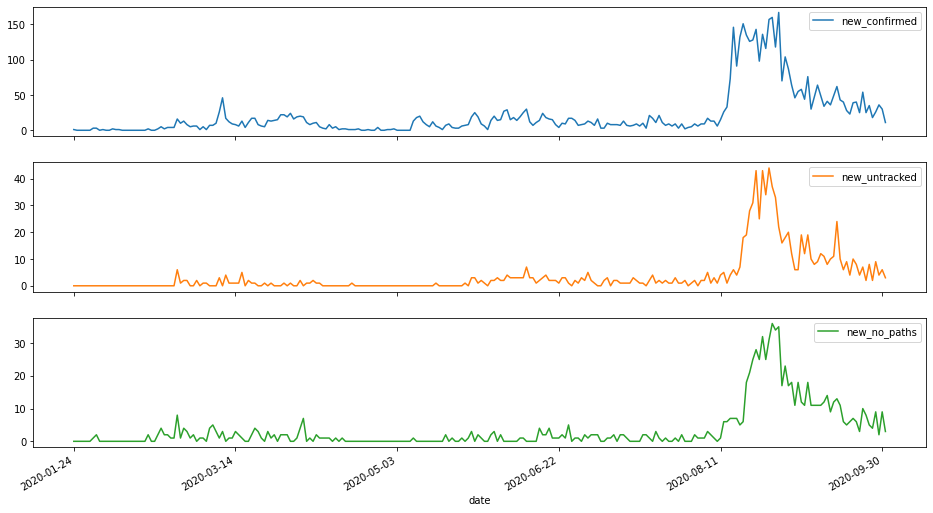

In [8]:
plot_cols = ['new_confirmed', 'new_untracked', 'new_no_paths']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(16,9))

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
new_confirmed,252.0,21.166667,33.082596,0.0,3.0,9.0,20.0,167.0
new_untracked,252.0,3.698413,7.511234,0.0,0.0,1.0,3.0,44.0
new_no_paths,252.0,3.535714,6.659229,0.0,0.0,1.0,3.0,36.0
is_holiday,252.0,0.039683,0.195601,0.0,0.0,0.0,0.0,1.0
is_weekend,252.0,0.428571,0.495856,0.0,0.0,0.0,1.0,1.0
gov_policy,252.0,0.476190,1.019447,0.0,0.0,0.0,0.0,3.0


In [10]:
shift_days = 1
shift_steps = shift_days * 5

In [11]:
# column that we want to predict
target_names = ['new_confirmed']
df_targets = df[target_names]

# shifting dataframe as much as steps
df_targets = df_targets.shift(-shift_steps)

In [12]:
# you can check that top 5 data is topped out
df_targets.head()

,new_confirmed
date,
2020-01-24,0.0
2020-01-25,3.0
2020-01-26,3.0
2020-01-27,0.0
2020-01-28,1.0


In [13]:
df_targets.tail(10)

,new_confirmed
date,
2020-09-22,18.0
2020-09-23,26.0
2020-09-24,36.0
2020-09-25,30.0
2020-09-26,11.0
2020-09-27,NaN
2020-09-28,NaN
2020-09-29,NaN
2020-09-30,NaN


In [14]:
x_data = df.values[shift_steps:]
print(type(x_data))
print("Shape:", x_data.shape)
x_data

<class 'numpy.ndarray'>
Shape: (247, 6)


array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  0.,  1.,  0.,  0.,  0.],
       [ 3.,  0.,  2.,  0.,  1.,  0.],
       ...,
       [36.,  4.,  2.,  0.,  0.,  2.],
       [30.,  6.,  9.,  1.,  0.,  2.],
       [11.,  3.,  3.,  1.,  0.,  2.]])

In [15]:
y_data = df_targets.values[shift_steps:]
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (247, 1)


In [16]:
num_data = len(x_data)
num_data

247

In [17]:
# train_split = 0.9
# num_train = int(train_split * num_data)
num_train = num_data - 5
num_train

242

In [18]:
num_test = num_data - num_train
num_test

5

In [19]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)


247

In [20]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

247

In [21]:
num_x_signals = x_data.shape[1]
num_x_signals

6

In [22]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [23]:
x_train

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  0.,  1.,  0.,  0.,  0.],
       [ 3.,  0.,  2.,  0.,  1.,  0.],
       ...,
       [54.,  7., 10.,  0.,  0.,  2.],
       [25.,  2.,  8.,  0.,  1.,  2.],
       [35.,  8.,  5.,  0.,  1.,  2.]])

In [24]:
# Scaler Class that shrinks number in between 0 and 1 for the purpose of neuron input
x_scaler = MinMaxScaler()

In [25]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0.0
Max: 167.0


In [26]:
x_train_scaled = x_scaler.fit_transform(x_train)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [27]:
x_test_scaled = x_scaler.transform(x_test)

In [28]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [29]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(242, 6)
(242, 1)


In [30]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [31]:
batch_size = 256

In [32]:
sequence_length = len(x_train_scaled) -1 
sequence_length

241

In [33]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [34]:
x_batch, y_batch = next(generator)

In [35]:
print(x_batch.shape)
print(y_batch.shape)

(256, 241, 6)
(256, 241, 1)


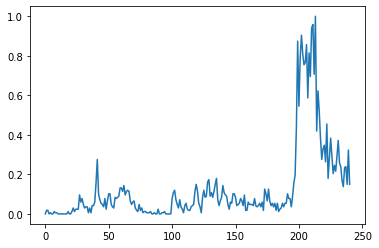

In [36]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

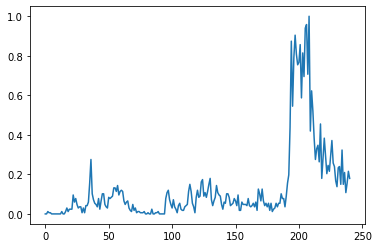

In [37]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [38]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [39]:
model = Sequential()

In [40]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [41]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [42]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [43]:
# ignoring data range, based on time steps
# warmup_steps = len(x_train) + len(x_test) - 16*7

# 바이러스 V형, S형은 더이상 검출되지 않으므로, 이태원클럽 이후에 퍼진 GH형만 따져보자
# 즉 이태원 이후의 데이터만 신경을 쓰기로 한다. 1월 24일 ~ 5월 2일 데이터는 무시
warmup_steps = 100

In [44]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [45]:
optimizer = RMSprop(lr=1e-3)

In [46]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         798720    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 799,233
Trainable params: 799,233
Non-trainable params: 0
_________________________________________________________________


In [48]:
path_checkpoint = '/content/covid19_unknown_spread/23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [49]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=10, verbose=1) # stop when result is not improved for 10 epochs

In [50]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [51]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-3,# minimum learning rate
                                       patience=0,
                                       verbose=1)

In [52]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [53]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
  1/100 [..............................] - ETA: 0s - loss: 0.1507WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
100/100 [==============================] - ETA: 0s - loss: 0.0310
Epoch 00001: val_loss did not improve from inf

Epoch 00001: ReduceLROnPlateau reducing learning rate to 0.001.
100/100 [==============================] - 5s 52ms/step - loss: 0.0310 - val_loss: nan
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0204
Epoch 00002: val_loss did not improve from inf

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.001.
100/100 [==============================] - 5s 46ms/step - loss: 0.0204 - val_loss: nan
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0189
Epoch 00003: val_loss did no

In [61]:
%reset plot_comparison

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  plot_comparison, please run `%reset?` for details


In [62]:
def plot_comparison_train(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    if not train:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    # print(len(y_pred_rescaled))

    if train:
      # 바이러스 V형, S형은 더이상 검출되지 않으므로, 이태원클럽 이후에 퍼진 GH형만 따져보자
      # 즉 이태원 이후의 데이터만 신경을 쓰기로 한다. 1월 24일 ~ 5월 2일 데이터는 무시
      warmup_steps = 100
    if not train:
      warmup_steps = 0
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        # print(signal)
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()
    return y_pred_rescaled

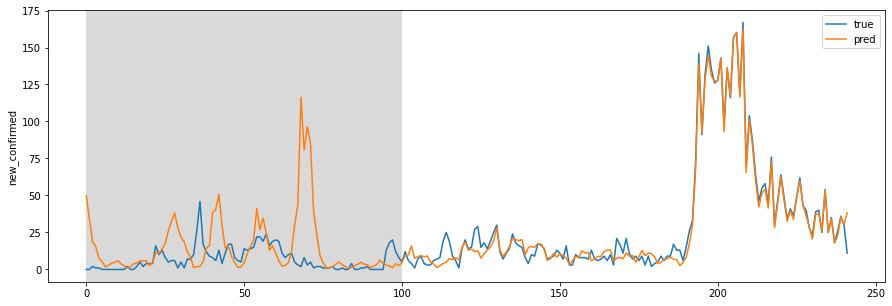

array([[ 49.71191   ],
       [ 34.115967  ],
       [ 18.540897  ],
       [ 15.5318985 ],
       [  7.6682    ],
       [  5.294399  ],
       [  1.8662868 ],
       [  2.6262975 ],
       [  4.168559  ],
       [  4.9133224 ],
       [  5.870222  ],
       [  3.7703302 ],
       [  2.5542762 ],
       [  1.0155014 ],
       [  1.830226  ],
       [  3.737979  ],
       [  4.346132  ],
       [  5.8192573 ],
       [  5.779109  ],
       [  5.9477816 ],
       [  2.5243053 ],
       [  4.8335347 ],
       [ 11.33966   ],
       [ 10.87665   ],
       [ 13.757309  ],
       [ 17.553064  ],
       [ 26.091356  ],
       [ 32.46097   ],
       [ 38.171837  ],
       [ 27.945358  ],
       [ 21.747055  ],
       [ 18.814135  ],
       [ 11.990044  ],
       [  8.379252  ],
       [  1.2941456 ],
       [  1.8980665 ],
       [  1.9373336 ],
       [  5.211842  ],
       [ 14.402808  ],
       [ 15.889807  ],
       [ 38.403244  ],
       [ 40.611763  ],
       [ 50.840626  ],
       [ 29

In [63]:
plot_comparison_train(start_idx=0, length=len(x_data), train=True)

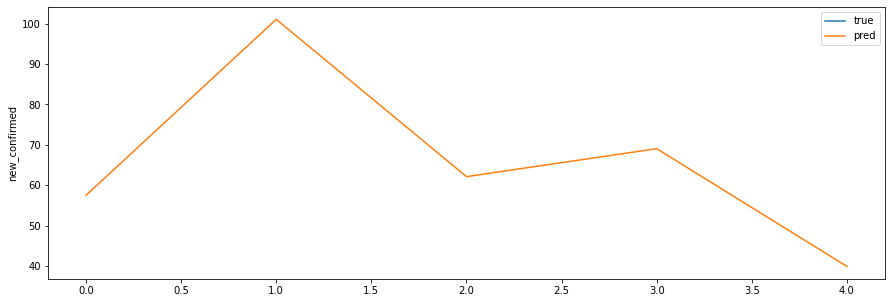

array([[ 57.507866],
       [101.06736 ],
       [ 62.12883 ],
       [ 69.04919 ],
       [ 39.893597]], dtype=float32)

In [64]:
plot_comparison_train(start_idx=0, length=5, train=False)